# CLIP vs ResNext Classification

#### Reference

- https://github.com/openai/CLIP
- https://openai.com/blog/clip/

In [1]:
COLAB = True

## Install the libraries

In [2]:
if COLAB:
  # --- Remember to change the runtime to use GPU for better performance
  !nvidia-smi
  !pip install -Uqq ftfy regex tqdm 
  !rm -rf jupyter-notebooks && git clone https://github.com/alpha2phi/jupyter-notebooks.git 
  !rm -rf CLIP && cp -R jupyter-notebooks/nbs/CLIP .
  !rm -rf test_data && cp -R jupyter-notebooks/nbs/test_data .
else:
  !pip install -Uqq ftfy regex tqdm torch torchvision

Wed Jan 13 01:40:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import Libaries and Model

In [3]:
import os
import glob
import torch
import torchvision.transforms as Transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from CLIP import clip
from PIL import Image
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Check pytorch version
print(f"PyTorch version - {torch.__version__}")

# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device - {device}")

# Load CLIP model
clip_model, clip_preprocess = clip.load('ViT-B/32', device)
clip_model.eval()

# Load ResNext model
resnext_model = torch.hub.load('pytorch/vision:v0.6.0', 'resnext50_32x4d', pretrained=True)
resnext_model.eval()

  3%|▊                      | 11673600/353976522 [00:00<00:02, 115370686.61it/s]

PyTorch version - 1.7.0+cu101
Device - cuda


100%|██████████████████████| 353976522/353976522 [00:02<00:00, 124181972.63it/s]
Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

## Prediction

In [10]:
with open("CLIP/imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

text = clip.tokenize(categories).to(device)

def predict_clip(image_file_path):
    image = clip_preprocess(Image.open(image_file_path)).unsqueeze(0).to(device)
    clip_model, _ = clip.load('ViT-B/32', device)

    # Calculate features
    with torch.no_grad():
        image_features = clip_model.encode_image(image)
        text_features = clip_model.encode_text(text)

    # Pick the top 5 most similar labels for the image
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(5)

    predictions = {}
    for value, index in zip(values, indices):
        predictions[f"{categories[index]:>16s}"] = f"{100 * value.item():.4f}%"
    return predictions


def predict_resnext(image_file_path):
    image = Image.open(image_file_path)
    preprocess = Transforms.Compose([
        Transforms.Resize(256),
        Transforms.CenterCrop(224),
        Transforms.ToTensor(),
        Transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        resnext_model.to('cuda')

    with torch.no_grad():
        output = resnext_model(input_batch)
    # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
    # print(output[0])
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    # print(probabilities)

    # Show top categories per image
    top5_prob, top5_catid = torch.topk(probabilities, 5)

    predictions = {}
    for i in range(top5_prob.size(0)):
        # print(categories[top5_catid[i]], top5_prob[i].item())
        predictions[f"{categories[top5_catid[i]]:16s}"] = f"{100 * top5_prob[i].item():.4f}%"
    return predictions


In [11]:
# Test ResNext

In [12]:
# Test CLIP


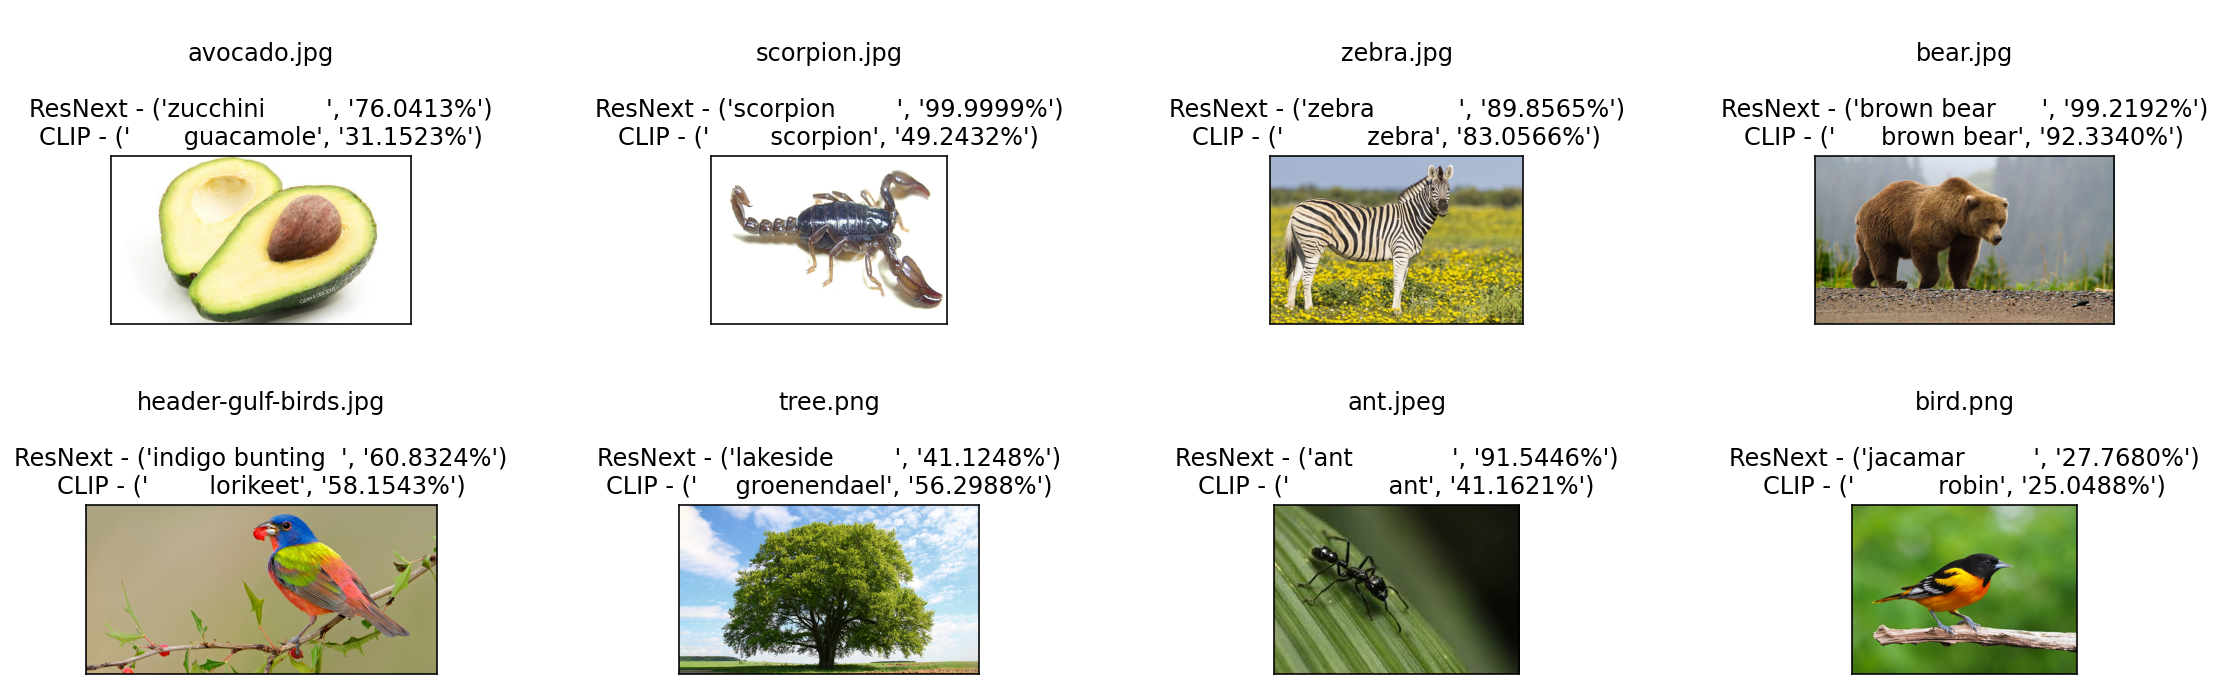

In [13]:
plt.figure(figsize=(16, 5))
images = glob.glob("test_data/images/*.*")
column = 4
row = len(images) / 4
index = 1
for f in images:
  plt.subplot(row, column, index)
  plt.imshow(Image.open(f).convert("RGB"))
  plt.title(f"\n{f.split('/')[2]}\n\nResNext - {list(predict_resnext(f).items())[0]}\nCLIP - {list(predict_clip(f).items())[0]}")
  plt.xticks([])
  plt.yticks([])
  index = index + 1

plt.tight_layout()
  